In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import tqdm

In [3]:
train_df = pd.read_csv("../data/processed/train.csv")
train_X = train_df.drop(['pt_loss'], axis=1)

val_df = pd.read_csv("../data/processed/train.csv")
val_X = val_df.drop(['pt_loss'], axis=1)

In [4]:
scaler = MinMaxScaler()
train_df.loc[:, :'RE'] = scaler.fit_transform(train_X.values)
val_df.loc[:, :'RE'] = scaler.transform(val_X.values)

In [5]:
class PtLossDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.length = df.shape[0]
        self.params = df.drop('pt_loss', axis=1).values.astype(np.float32)
        self.losses = df['pt_loss'].values.astype(np.float32)
    
    def __getitem__(self, ind: int) -> tuple[np.ndarray, np.ndarray]:
        return self.params[ind, :], self.losses[ind]
    
    def __len__(self) -> int:
        return self.length

In [6]:
train_dataset = PtLossDataset(train_df)
val_dataset = PtLossDataset(val_df)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=32, num_workers=4)

In [7]:
from collections import OrderedDict


class PtLossRegressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int = 1,
        num_layers: int = 2,
    ) -> None:
        super().__init__()

        self.layers = self._create_linear_layer(0, input_dim, hidden_dim)
        for i in range(num_layers - 2):
            self.layers += self._create_linear_layer(
                i + 1, hidden_dim, hidden_dim
            )

        self.layers += self._create_linear_layer(
            num_layers - 1, hidden_dim, output_dim, is_last=True
        )
        self.layers = nn.Sequential(OrderedDict(self.layers))

    def _create_linear_layer(
        self, num: int, input_dim: int, output_dim: int, is_last: bool = False
    ) -> list[tuple[str, nn.Module]]:
        layers = [(f"lin_{num}", nn.Linear(input_dim, output_dim))]
        if not is_last:
            layers.append((f"relu_{num}", nn.Tanh()))
        return layers

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

In [20]:
model = PtLossRegressor(7, 7, 1, num_layers=2).float()
loss_func = nn.MSELoss()

In [21]:
optim = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optim, step_size=100, gamma=0.1)

In [30]:
epochs = 500

tolerance = 1e-8
n_convergence_steps = 5
conv_counter = 0
report_interval = 10

train_loss_history = []
val_loss_history = []
train_metric_history = []
val_metric_history = []

for epoch in tqdm.tqdm(range(epochs)):

    best_params = model.state_dict()
    best_val_metric = 0.0

    model.train()

    train_mean_loss = []
    train_mean_metric = []

    for X, y in train_loader:
        X = X.float()
        y = y.float()
        preds = model(X)
        loss = loss_func(preds[:, 0], y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_mean_loss.append(loss.item())
        train_mean_metric.append(r2_score(y.numpy(), preds[:, 0].detach().numpy()))

    train_mean_loss = np.mean(train_mean_loss)
    train_mean_metric = np.mean(train_mean_metric)

    model.eval()

    val_mean_loss = []
    val_mean_metric = []

    for X, y in val_loader:
        X = X.float()
        y = y.float()
        with torch.set_grad_enabled(False):
            preds = model(X)
            loss = loss_func(preds[:, 0], y)

        val_mean_loss.append(loss.item())
        val_mean_metric.append(r2_score(y.numpy(), preds[:, 0].numpy()))
    
    val_mean_loss = np.mean(val_mean_loss)
    val_mean_metric = np.mean(val_mean_metric)

    if epoch > 0:
        if abs(train_loss_history[-1] - train_mean_loss) < tolerance:
            if conv_counter > n_convergence_steps:
                break
            else:
                conv_counter += 1
        else:
            conv_counter = 0

    train_loss_history.append(train_mean_loss)
    train_metric_history.append(train_mean_metric)
    val_metric_history.append(val_mean_metric)
    val_loss_history.append(val_mean_loss)

    if (epoch + 1) % report_interval == 0:
        print("#" * 50)
        print(f"Epoch: {epoch + 1} / {epochs}")
        print(f"Train loss: {train_loss_history[-1]}")
        print(f"Train r2 score: {train_metric_history[-1]}")
        print(f"Val loss: {val_loss_history[-1]}")
        print(f"Val r2 score: {val_metric_history[-1]}")
        print("#" * 50)
        print()

    if val_mean_metric > best_val_metric:
        best_val_metric = val_mean_metric
        best_params = model.state_dict()

    scheduler.step()

  2%|▏         | 10/500 [00:03<02:40,  3.06it/s]

##################################################
Epoch: 10 / 500
Train loss: 0.005259574032388628
Train r2 score: 0.7146294472064194
Val loss: 0.00535859472118318
Val r2 score: 0.7149855121884272
##################################################



  4%|▍         | 20/500 [00:06<02:17,  3.50it/s]

##################################################
Epoch: 20 / 500
Train loss: 0.005208591823466122
Train r2 score: 0.7185515947999391
Val loss: 0.005355975334532559
Val r2 score: 0.7177451680324825
##################################################



  6%|▌         | 30/500 [00:09<02:10,  3.60it/s]

##################################################
Epoch: 30 / 500
Train loss: 0.005184315014630556
Train r2 score: 0.7226969842448204
Val loss: 0.005328041105531156
Val r2 score: 0.7194569873102542
##################################################



  8%|▊         | 40/500 [00:11<02:11,  3.51it/s]

##################################################
Epoch: 40 / 500
Train loss: 0.005084444701205939
Train r2 score: 0.7254378298260664
Val loss: 0.005226969891227781
Val r2 score: 0.7253753789203298
##################################################



 10%|█         | 50/500 [00:15<02:09,  3.47it/s]

##################################################
Epoch: 50 / 500
Train loss: 0.0051306490600109105
Train r2 score: 0.7221814131787053
Val loss: 0.005215650242753327
Val r2 score: 0.7266763477905301
##################################################



 12%|█▏        | 60/500 [00:17<02:13,  3.29it/s]

##################################################
Epoch: 60 / 500
Train loss: 0.0050770295364782215
Train r2 score: 0.7306939932751952
Val loss: 0.005141480290330946
Val r2 score: 0.7281848770911463
##################################################



 14%|█▍        | 70/500 [00:20<02:08,  3.35it/s]

##################################################
Epoch: 70 / 500
Train loss: 0.004977921550162137
Train r2 score: 0.7453031245014797
Val loss: 0.005097980052232743
Val r2 score: 0.7330380209877957
##################################################



 16%|█▌        | 80/500 [00:23<02:07,  3.29it/s]

##################################################
Epoch: 80 / 500
Train loss: 0.005143856289796531
Train r2 score: 0.7447280080464193
Val loss: 0.0050725051155313845
Val r2 score: 0.7334361265505381
##################################################



 18%|█▊        | 90/500 [00:26<01:56,  3.51it/s]

##################################################
Epoch: 90 / 500
Train loss: 0.004943120758980513
Train r2 score: 0.7400124892614574
Val loss: 0.005114277903921902
Val r2 score: 0.7338774013045598
##################################################



 20%|██        | 100/500 [00:29<01:48,  3.69it/s]

##################################################
Epoch: 100 / 500
Train loss: 0.004912875797599554
Train r2 score: 0.7488625910017354
Val loss: 0.005013315263204277
Val r2 score: 0.7395797909571121
##################################################



 22%|██▏       | 110/500 [00:32<01:47,  3.63it/s]

##################################################
Epoch: 110 / 500
Train loss: 0.00487937131896615
Train r2 score: 0.755124217858073
Val loss: 0.0050089956168085335
Val r2 score: 0.739299371345851
##################################################



 24%|██▍       | 120/500 [00:35<01:50,  3.45it/s]

##################################################
Epoch: 120 / 500
Train loss: 0.00493244462646544
Train r2 score: 0.7427282143438344
Val loss: 0.005009993221610784
Val r2 score: 0.7374793064004109
##################################################



 26%|██▌       | 130/500 [00:38<01:41,  3.63it/s]

##################################################
Epoch: 130 / 500
Train loss: 0.005204401882365346
Train r2 score: 0.6975146085728425
Val loss: 0.005001621223054826
Val r2 score: 0.7398366126676856
##################################################



 28%|██▊       | 140/500 [00:40<01:40,  3.58it/s]

##################################################
Epoch: 140 / 500
Train loss: 0.004867200418375433
Train r2 score: 0.7496144115551227
Val loss: 0.004999698242172599
Val r2 score: 0.7404158426041725
##################################################



 30%|███       | 150/500 [00:43<01:34,  3.69it/s]

##################################################
Epoch: 150 / 500
Train loss: 0.004978785838466138
Train r2 score: 0.7388342216232842
Val loss: 0.004992137909866869
Val r2 score: 0.7399169038344149
##################################################



 32%|███▏      | 160/500 [00:46<01:46,  3.20it/s]

##################################################
Epoch: 160 / 500
Train loss: 0.0049046675069257615
Train r2 score: 0.7465710729697562
Val loss: 0.004989299941807985
Val r2 score: 0.7406141260409684
##################################################



 34%|███▍      | 170/500 [00:49<01:34,  3.49it/s]

##################################################
Epoch: 170 / 500
Train loss: 0.004843928557820618
Train r2 score: 0.7519513557129766
Val loss: 0.00498462279792875
Val r2 score: 0.7404007277141323
##################################################



 36%|███▌      | 180/500 [00:52<01:35,  3.37it/s]

##################################################
Epoch: 180 / 500
Train loss: 0.004872655645012856
Train r2 score: 0.7525173548846356
Val loss: 0.004980489197187125
Val r2 score: 0.7408601799295232
##################################################



 38%|███▊      | 190/500 [00:55<01:27,  3.53it/s]

##################################################
Epoch: 190 / 500
Train loss: 0.004858572469092905
Train r2 score: 0.7474283523847809
Val loss: 0.004977746699005366
Val r2 score: 0.7416084921474884
##################################################



 40%|████      | 200/500 [00:58<01:34,  3.19it/s]

##################################################
Epoch: 200 / 500
Train loss: 0.004934930864255876
Train r2 score: 0.7534292717135882
Val loss: 0.004975933893583715
Val r2 score: 0.741705981028971
##################################################



 42%|████▏     | 210/500 [01:02<02:07,  2.28it/s]

##################################################
Epoch: 210 / 500
Train loss: 0.004873330383561552
Train r2 score: 0.7547788834414301
Val loss: 0.0049750103941187266
Val r2 score: 0.7416725908495875
##################################################



 44%|████▍     | 220/500 [01:07<02:23,  1.96it/s]

##################################################
Epoch: 220 / 500
Train loss: 0.004794862909475342
Train r2 score: 0.7567255881971475
Val loss: 0.004974333471618592
Val r2 score: 0.7415940114476082
##################################################



 46%|████▌     | 230/500 [01:11<01:23,  3.22it/s]

##################################################
Epoch: 230 / 500
Train loss: 0.004932002355344594
Train r2 score: 0.7465584180465353
Val loss: 0.004974229400977493
Val r2 score: 0.741727800391937
##################################################



 48%|████▊     | 240/500 [01:15<01:41,  2.56it/s]

##################################################
Epoch: 240 / 500
Train loss: 0.004846948394551873
Train r2 score: 0.7635740025473874
Val loss: 0.004974213284440338
Val r2 score: 0.7418587574184405
##################################################



 50%|█████     | 250/500 [01:19<01:32,  2.71it/s]

##################################################
Epoch: 250 / 500
Train loss: 0.005245076422579586
Train r2 score: 0.752756425077167
Val loss: 0.0049735720502212645
Val r2 score: 0.7418690522305065
##################################################



 52%|█████▏    | 260/500 [01:21<01:08,  3.49it/s]

##################################################
Epoch: 260 / 500
Train loss: 0.004844417134299874
Train r2 score: 0.7542232938991134
Val loss: 0.004973251563496888
Val r2 score: 0.7419033884072053
##################################################



 54%|█████▍    | 270/500 [01:24<01:02,  3.67it/s]

##################################################
Epoch: 270 / 500
Train loss: 0.0048263164097443224
Train r2 score: 0.7544875816814802
Val loss: 0.004972435869276524
Val r2 score: 0.7418833957717319
##################################################



 56%|█████▌    | 280/500 [01:27<01:04,  3.40it/s]

##################################################
Epoch: 280 / 500
Train loss: 0.004867669614031911
Train r2 score: 0.7509008837491038
Val loss: 0.004971581101417541
Val r2 score: 0.7416005636602513
##################################################



 58%|█████▊    | 290/500 [01:30<01:03,  3.28it/s]

##################################################
Epoch: 290 / 500
Train loss: 0.0048310886695981025
Train r2 score: 0.7565934954264506
Val loss: 0.004972149808891118
Val r2 score: 0.7419413898564301
##################################################



 60%|██████    | 300/500 [01:33<00:57,  3.45it/s]

##################################################
Epoch: 300 / 500
Train loss: 0.004856946053914726
Train r2 score: 0.7580853779978455
Val loss: 0.004971855850890279
Val r2 score: 0.741933797787453
##################################################



 62%|██████▏   | 310/500 [01:36<00:52,  3.59it/s]

##################################################
Epoch: 310 / 500
Train loss: 0.004857589788734913
Train r2 score: 0.7574090587510917
Val loss: 0.004971771277487278
Val r2 score: 0.7419283140314177
##################################################



 64%|██████▍   | 320/500 [01:39<00:48,  3.71it/s]

##################################################
Epoch: 320 / 500
Train loss: 0.004898768849670887
Train r2 score: 0.7549630963881251
Val loss: 0.004971602708101272
Val r2 score: 0.7419043167725945
##################################################



 66%|██████▌   | 330/500 [01:42<00:48,  3.53it/s]

##################################################
Epoch: 330 / 500
Train loss: 0.00493374478071928
Train r2 score: 0.7176139506106053
Val loss: 0.004971484318375587
Val r2 score: 0.7418858451970425
##################################################



 68%|██████▊   | 340/500 [01:45<00:44,  3.63it/s]

##################################################
Epoch: 340 / 500
Train loss: 0.004861810435540974
Train r2 score: 0.7590931208106231
Val loss: 0.004971457524225116
Val r2 score: 0.7418904362303412
##################################################



 70%|███████   | 350/500 [01:48<00:45,  3.31it/s]

##################################################
Epoch: 350 / 500
Train loss: 0.00485521593131125
Train r2 score: 0.7533269746801402
Val loss: 0.004971406101249159
Val r2 score: 0.741887906781439
##################################################



 72%|███████▏  | 360/500 [01:51<00:38,  3.60it/s]

##################################################
Epoch: 360 / 500
Train loss: 0.004868721924722195
Train r2 score: 0.7567145660737554
Val loss: 0.004971441305242479
Val r2 score: 0.7419056705708376
##################################################



 74%|███████▍  | 370/500 [01:55<00:54,  2.36it/s]

##################################################
Epoch: 370 / 500
Train loss: 0.004814431616105139
Train r2 score: 0.7696995874935808
Val loss: 0.00497143151704222
Val r2 score: 0.7419171875865165
##################################################



 76%|███████▌  | 380/500 [01:58<00:35,  3.42it/s]

##################################################
Epoch: 380 / 500
Train loss: 0.0048704392928630115
Train r2 score: 0.7593071140684774
Val loss: 0.004971437053754925
Val r2 score: 0.7419350928362288
##################################################



 78%|███████▊  | 390/500 [02:01<00:30,  3.57it/s]

##################################################
Epoch: 390 / 500
Train loss: 0.004849307499825955
Train r2 score: 0.74911829781313
Val loss: 0.004971437607891858
Val r2 score: 0.7419483301471067
##################################################



 80%|████████  | 400/500 [02:04<00:28,  3.53it/s]

##################################################
Epoch: 400 / 500
Train loss: 0.004826741372235119
Train r2 score: 0.7569576240836183
Val loss: 0.004971377933397889
Val r2 score: 0.7419458389850042
##################################################



 82%|████████▏ | 410/500 [02:06<00:24,  3.75it/s]

##################################################
Epoch: 410 / 500
Train loss: 0.0048009024746716025
Train r2 score: 0.7605141714270252
Val loss: 0.004971371018327773
Val r2 score: 0.7419454210597358
##################################################



 84%|████████▍ | 420/500 [02:09<00:22,  3.63it/s]

##################################################
Epoch: 420 / 500
Train loss: 0.004841031711548567
Train r2 score: 0.7432457730734373
Val loss: 0.004971373151056469
Val r2 score: 0.7419468676634676
##################################################



 86%|████████▌ | 430/500 [02:12<00:22,  3.10it/s]

##################################################
Epoch: 430 / 500
Train loss: 0.004802079759538174
Train r2 score: 0.762295060899268
Val loss: 0.004971369253471494
Val r2 score: 0.7419474332786309
##################################################



 88%|████████▊ | 440/500 [02:16<00:17,  3.34it/s]

##################################################
Epoch: 440 / 500
Train loss: 0.00488488064147532
Train r2 score: 0.747159744236461
Val loss: 0.0049713687831535935
Val r2 score: 0.7419485851095979
##################################################



 90%|█████████ | 450/500 [02:20<00:18,  2.64it/s]

##################################################
Epoch: 450 / 500
Train loss: 0.004855285119265318
Train r2 score: 0.74796734627936
Val loss: 0.004971372429281473
Val r2 score: 0.7419501671604799
##################################################



 92%|█████████▏| 460/500 [02:24<00:18,  2.12it/s]

##################################################
Epoch: 460 / 500
Train loss: 0.004873784449882805
Train r2 score: 0.7518338003277768
Val loss: 0.004971366268582642
Val r2 score: 0.7419501045240309
##################################################



 94%|█████████▍| 470/500 [02:28<00:12,  2.37it/s]

##################################################
Epoch: 470 / 500
Train loss: 0.004852208024822176
Train r2 score: 0.7496286713833985
Val loss: 0.004971362622454762
Val r2 score: 0.7419509441842251
##################################################



 96%|█████████▌| 480/500 [02:32<00:06,  3.10it/s]

##################################################
Epoch: 480 / 500
Train loss: 0.004845834705047309
Train r2 score: 0.7547640805534863
Val loss: 0.0049713611090555785
Val r2 score: 0.7419519305028203
##################################################



 98%|█████████▊| 490/500 [02:35<00:03,  3.19it/s]

##################################################
Epoch: 490 / 500
Train loss: 0.004883928019553423
Train r2 score: 0.7448912409350705
Val loss: 0.0049713588831946254
Val r2 score: 0.7419525430739555
##################################################



100%|██████████| 500/500 [02:40<00:00,  3.12it/s]

##################################################
Epoch: 500 / 500
Train loss: 0.004873105892911554
Train r2 score: 0.7581258525830313
Val loss: 0.00497135900426656
Val r2 score: 0.741953148004561
##################################################



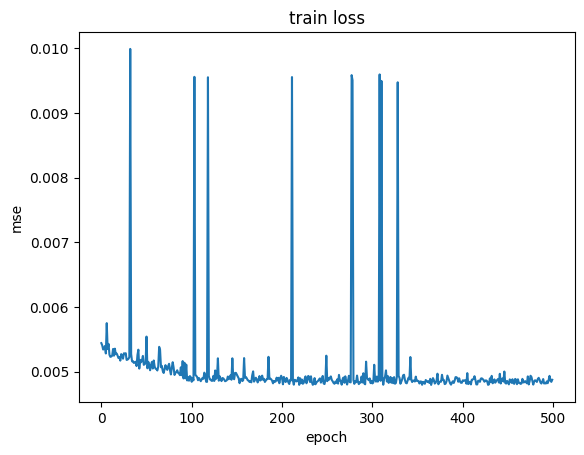

In [31]:
plt.plot(train_loss_history)
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

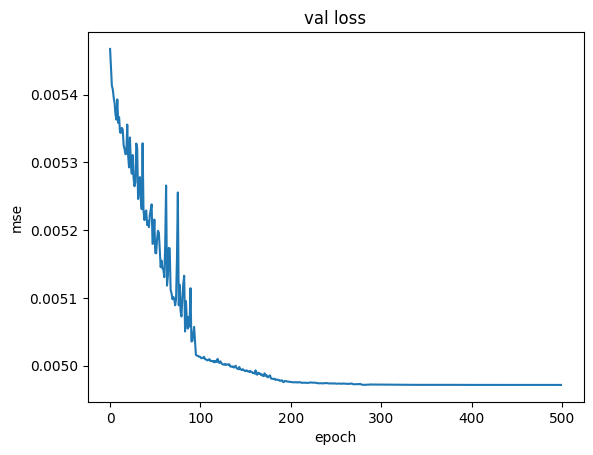

In [33]:
plt.plot(val_loss_history)
plt.title("val loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

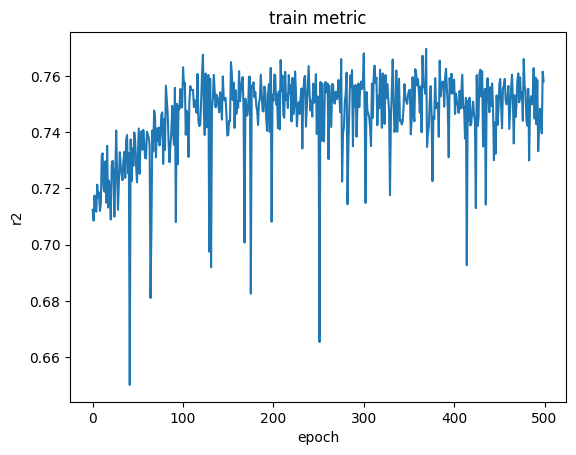

In [35]:
plt.plot(train_metric_history)
plt.title("train metric")
plt.xlabel("epoch")
plt.ylabel("r2")
plt.show()

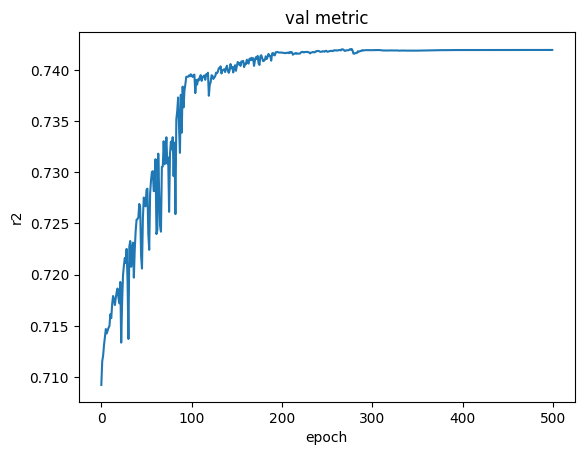

In [36]:
plt.plot(val_metric_history)
plt.title("val metric")
plt.xlabel("epoch")
plt.ylabel("r2")
plt.show()